In [ ]:
import keras
from math import sqrt
from keras.layers import Input, Dense, Reshape, Dropout, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose , Concatenate ,Permute
from keras.layers import BatchNormalization ,Activation , UpSampling2D,TimeDistributed ,LSTM , Lambda
from keras.layers.merge import Dot
from keras.models import Model 
from keras.datasets import mnist , fashion_mnist
from keras.optimizers import Adadelta, RMSprop
import numpy as np
from keras.utils.data_utils import get_file
from sklearn.utils import shuffle
import random
import sys 
import keras.backend as K

Using TensorFlow backend.


In [ ]:
path = get_file('images_background.zip', origin='https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip')
import zipfile
with zipfile.ZipFile(path,"r") as zip_ref:
    zip_ref.extractall("omnilogt")
   

In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train_mnist.reshape(60000,28,28,1)
x_test_mnist = x_test_mnist.reshape(10000,28,28,1)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255
y_train_mnist = keras.utils.to_categorical(y_train_mnist, 20)
y_test_mnist = keras.utils.to_categorical(y_test_mnist, 20)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
x_train_fashion = x_train_fashion.reshape(60000,28,28,1)
x_test_fashion = x_test_fashion.reshape(10000,28,28,1)
x_train_fashion = x_train_fashion.astype('float32')
x_test_fashion = x_test_fashion.astype('float32')
y_train_fashion = y_train_fashion.astype('int8')
y_test_fashion = y_test_fashion.astype('int8')
x_train_fashion /= 255
x_test_fashion /= 255
y_train_fashion += 10
y_test_fashion += 10
y_train_fashion = keras.utils.to_categorical(y_train_fashion, 20)
y_test_fashion = keras.utils.to_categorical(y_test_fashion, 20)
y_train = np.concatenate([y_train_mnist,y_train_fashion],axis=0)
x_train = np.concatenate([x_train_mnist,x_train_fashion],axis=0)
x_test = np.concatenate([x_test_mnist,x_test_fashion],axis=0)
y_test = np.concatenate([y_test_mnist,y_test_fashion],axis=0)
x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

4423680/4422102 [==============================] - 1s 0us/step


In [ ]:
print (x_train.shape)
input_shape = (28,28,1)
maps = 32 
dropout = 0.2
hidden = 256
slotsize = 256
num_classes = 20 

(120000, 28, 28, 1)


In [ ]:
#decoder
input_feature = Input(shape=(slotsize, ))
input_feature_reshape = Reshape((int(sqrt(hidden)), int(sqrt(hidden)), 1))(input_feature)
upconv = Conv2DTranspose(maps, (5, 5), activation='relu')(input_feature_reshape)
upconv = Dropout(dropout)(upconv)
upconv = Conv2DTranspose(maps, (5, 5), activation='relu')(upconv)
upconv = Dropout(dropout)(upconv)
image = Conv2DTranspose(1, (5, 5), activation='relu')(upconv)
decoder = Model(inputs=input_feature, outputs=image, name='Decoder')
#memory_writer 
input_images = Input(shape=(None,28,28,1))
x = TimeDistributed(Conv2D(32, (3, 3), padding='same'))(input_images)
x = TimeDistributed(Activation('relu'))(x)
x = Dropout(dropout)(x)
x = TimeDistributed(Conv2D(32, (3, 3), padding='same'))(x)
x = TimeDistributed(Activation('relu'))(x)
x = Dropout(dropout)(x)
x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
encoded = TimeDistributed(Flatten())(x)
encoded = TimeDistributed(Dense(slotsize, activation='relu'))(encoded)
memory_writer = Model([input_images], [encoded], name='memory_writer')
#ltmn
sim = Dot(-1,normalize = True, name='cos_sim')
#sim = TimeDistributed(Dense(hidden,activation='softmax'))
read_weights = Activation('softmax')
read_vector = Lambda(lambda x: K.batch_dot(x[0],x[1]),name='read_vector')
y = Input(shape=(num_classes,))
y_v = Dense(256)(y)
i_m = memory_writer([input_images])
sim_score = sim([y_v, i_m])
weights = read_weights(sim_score)
rt = read_vector([weights,i_m])
image = decoder(rt)
LTMN = Model([input_images, y], image, name='LTMN')
LTMN.compile(optimizer= RMSprop(), loss='mse')
LTMN.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "LTMN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 28, 28, 0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          5376        input_3[0][0]                    
__________________________________________________________________________________________________
memory_writer (Model)           (None, None, 256)    1615456     input_2[

In [ ]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

IndexError: ignored

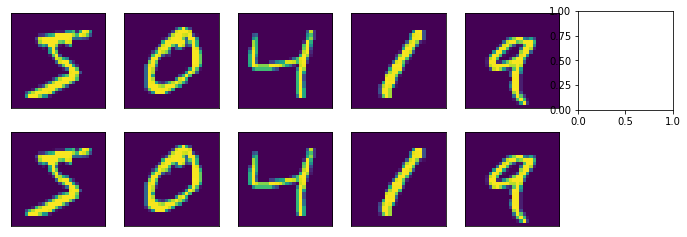

In [ ]:
showOrigDec(x_train_mnist[0:5],x_train_mnist[0:5])

In [ ]:
def generatememorybatch(mem_size,batch_size):
  x_f = np.zeros((batch_size,mem_size,28,28,1))
  for i in range(batch_size):
    for t in range(mem_size):
      index = np.random.randint(0,x_train.shape[0])
      x_f[i,t] = x_train[index]
  return x_f
def generaterandomsample(x_test, y_test, size=1000):
    y_ = y_test[0:size]
    x_ = x_test[0:size]
    indices = random.sample(range(0, y_test.shape[0]), size)
    for i in range(size):
      y_[i] = y_test[indices[i]]
      x_[i] = x_test[indices[i]]
    return x_,y_
loss = 0
#losses = []
for i in range(20000):
  x_f = generatememorybatch(10,256)
  x_t, y_t = generaterandomsample(x_train,y_train,256)
  loss += LTMN.train_on_batch([x_f,y_t],x_t)
  sys.stdout.write('\r Epoch  {} , loss = {}'.format(i+1,loss/(i+1)))
  sys.stdout.flush()
  if (i+1) % 1000 == 0:
    x_f = np.zeros((5,5,28,28,1))
    y_f = np.zeros((5,num_classes))
    x_images = np.zeros((5,28,28,1))
    for t in range(5):
      index = np.random.randint(0,x_test.shape[0])
      x_f[:,t] = x_test[index]
      x_images[t] = x_test[index]
      y_f[t] = y_test[index]
       
    preds = LTMN.predict([x_f,y_f])
    showOrigDec(x_images,preds,num=5)

  #losses.append(loss/(i+1))
#print losses[-1]
  

 Epoch  26 , loss = 0.07515070816645256